**Installing the necessary libraries**

In [29]:
!pip install opencv-python

import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import files
from io import BytesIO

%matplotlib inline

**Loading an image from the computer**

In [30]:
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
image = cv2.imdecode(np.frombuffer(uploaded[image_path], np.uint8), cv2.IMREAD_COLOR)


Saving Cubo_giallo.png to Cubo_giallo.png


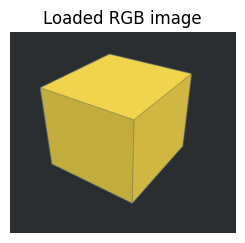

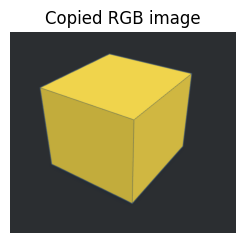

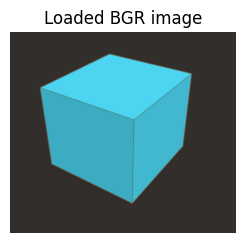

(1032, 1158, 3)


In [31]:
#Convert the image from BGR to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)

#Display the image using matplotlib
plt.imshow(image_rgb)
plt.title('Loaded RGB image')
plt.axis('off')
plt.show()

plt.subplot(1, 2, 1)
#Display the image using matplotlib
copia = image_rgb.copy()
plt.imshow(copia)
plt.title('Copied RGB image')
plt.axis('off')
plt.show()

#Display the image using matplotlib
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Loaded BGR image')
plt.axis('off')
plt.show()

print(image.shape)

In [32]:
def generate_grasp_positions(num_positions, img_shape, mask):
    """
    Generates a specific number of grasp positions within the mask.

    :param num_positions: Number of grasp positions to generate
    :param img_shape: Dimensions of the image (height, width, channels)
    :param mask: Binary mask of the object (255 for the object, 0 for the background)
    :return: List of tuples (x, y, c) representing the grasp positions
    """
    height, width = img_shape[:2]
    num_channels = img_shape[2]

    #Find the coordinates of the pixels belonging to the object
    object_pixels = np.argwhere(mask == 255)

    if len(object_pixels) == 0:
        raise ValueError("The mask does not contain any object pixels.")

    #Select a specific number of grasp positions
    if num_positions > len(object_pixels):
        num_positions = len(object_pixels)
        print(f"The requested number of positions is greater than the number of object pixels. I will use {num_positions} positions.")

    selected_indices = np.random.choice(len(object_pixels), size=num_positions, replace=False)
    positions = []

    for idx in selected_indices:
        x, y = object_pixels[idx]
        for c in range(num_channels):  #Iterate over the channels
            positions.append((x, y, c))

    #Debug
    print(f"Number of positions generated: {len(positions)}")

    return positions


In [33]:
def calculate_center_of_mass(mask):
    moments = cv2.moments(mask)
    if moments["m00"] != 0:
        cX = int(moments["m10"] / moments["m00"])
        cY = int(moments["m01"] / moments["m00"])

    else:
        cX, cY = 0, 0
    return cX, cY

def segment_object(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    #Morphological operations to enhance the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  #Fills the holes in the object
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   #Removes noise

    return mask

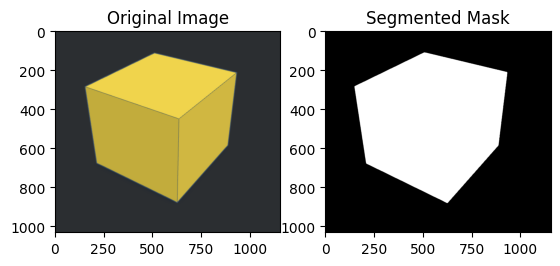

In [34]:
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')

plt.subplot(1, 2, 2)
mask = segment_object(image)
plt.imshow(mask, cmap='gray')
plt.title('Segmented Mask')
plt.show()

In [35]:
print(mask.shape)

(1032, 1158)


In [36]:
num_object_pixels = np.sum(mask == 255)
print(f"Number of object pixels: {num_object_pixels}")

Number of object pixels: 427186


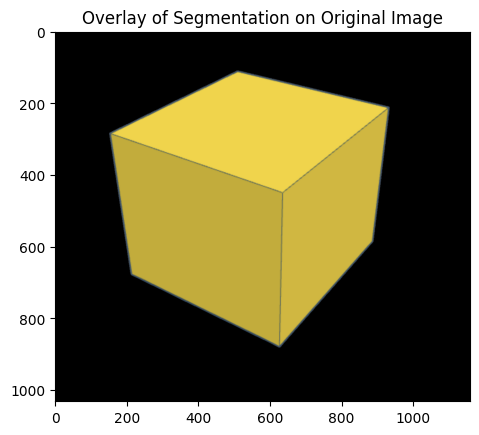

In [37]:
overlay = image.copy()
overlay[mask == 0] = [0, 0, 0]  #Set the background pixels to black
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay of Segmentation on Original Image')
plt.show()

In [38]:
def evaluate_grasp_positions(grasp_positions, center_of_mass, acceptable_range):
    evaluations = []
    for pos in grasp_positions:
        distance = np.sqrt((pos[0] - center_of_mass[0])**2 + (pos[1] - center_of_mass[1])**2)
        is_correct = "correct" if distance <= acceptable_range else "wrong"
        evaluations.append((pos[0], pos[1], pos[2], distance, is_correct))

    return evaluations

In [39]:
def create_evaluation_table(evaluations):
  df = pd.DataFrame(evaluations, columns=["x", "y", "c", "distance_from_center", "evaluation"])
  return df

In [40]:
def proj_x_y(evaluation_table):
  #Filter only the x and y columns
  df_filtered = evaluation_table[["x", "y"]]

  #Print the filtered DataFrame
  return df_filtered

In [41]:
print(image_rgb.shape)

(1032, 1158, 3)


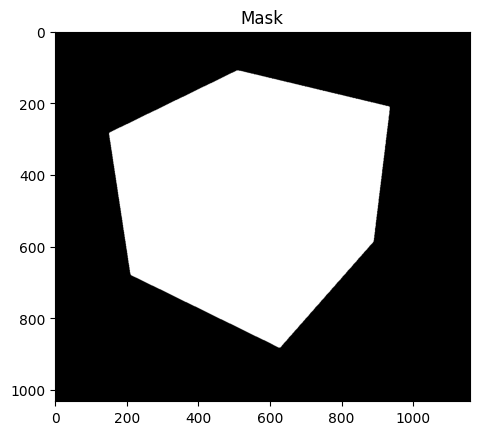

Number of positions generated: 1500
        x    y  c  distance_from_center evaluation
0     396  198  0            304.507800      wrong
1     396  198  1            304.507800      wrong
2     396  198  2            304.507800      wrong
3     732  725  0            321.309819      wrong
4     732  725  1            321.309819      wrong
...   ...  ... ..                   ...        ...
1495  618  589  1            145.120639      wrong
1496  618  589  2            145.120639      wrong
1497  478  383  0            104.995238      wrong
1498  478  383  1            104.995238      wrong
1499  478  383  2            104.995238      wrong

[1500 rows x 5 columns]


In [42]:
#Segment the object and calculate the center of mass
mask = segment_object(image)
center_of_mass = calculate_center_of_mass(mask)
num_positions = 400
img_shape=image_rgb.shape

#Verify the mask
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

#Generate grasp positions
grasp_positions = generate_grasp_positions(num_positions, img_shape, mask)

#Evaluate the grasp positions
acceptable_range = 100  #Define an acceptable range
evaluations = evaluate_grasp_positions(grasp_positions, center_of_mass, acceptable_range)

#Create the evaluation table
evaluation_table = create_evaluation_table(evaluations)
#Display the table
print(evaluation_table)


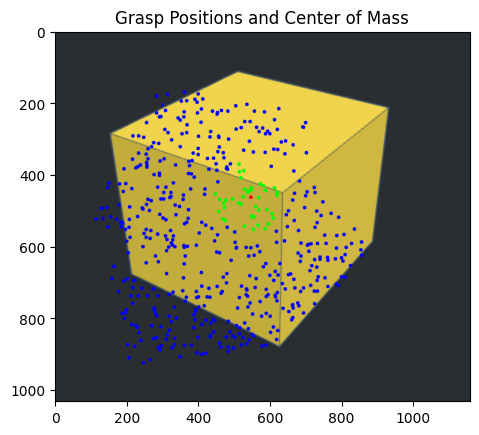

In [43]:
x_y = proj_x_y(evaluation_table)

for _, row in evaluation_table.iterrows():
    x = row['x']
    y = row['y']

    #Apply the function that requires x and y values
    proj = (x, y)

    if row['evaluation'] == "correct":
        cv2.circle(image, proj, 5, (0, 255, 0), -1)  #Green for correct positions
    else:
        cv2.circle(image, proj, 5, (255, 0, 0), -1)  #Blue for incorrect positions

cv2.circle(image, center_of_mass, 5, (0, 0, 255), -1)  #Red for the center of mass

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Grasp Positions and Center of Mass')
plt.show()

**DATASET CREATION**

In [44]:
def proj_column(evaluation_table, column_index):
  #Define the column names for the DataFrame
  column_names = ['x', 'y', 'c', 'distance_from_center', 'evaluation']

  #Verify that the column index is valid
  if column_index < 0 or column_index >= len(column_names):
    raise ValueError("Invalid column index. It must be between 0 and 4")

  #Select the column name based on the index
  name_column = column_names[column_index]

  #Project only the specified column
  column_data = evaluation_table[name_column]

  # Restituisci la colonna proiettata
  return column_data

In [45]:
#Load the table
data = pd.DataFrame({
    'x': proj_column(evaluation_table, 0),
    'y': proj_column(evaluation_table, 1),
    'c': proj_column(evaluation_table, 2),
    'distance_from_center': proj_column(evaluation_table, 3),
    'evaluation': proj_column(evaluation_table, 4)
})
data['evaluation'] = data['evaluation'].apply(lambda x: 1 if x == 'correct' else 0)
#Load the image (assuming it is the same for all rows)
cubo = cv2.imread('/content/Cubo_giallo.png')

cubo_rgb = cv2.cvtColor(cubo, cv2.COLOR_BGR2RGB)
#Resize and normalize the image
cubo = cv2.resize(cubo, (224, 224))
cubo = cubo / 255.0
print(np.min(cubo), np.max(cubo))

0.13725490196078433 0.9411764705882353


        x    y  c  distance_from_center  evaluation
0     396  198  0            304.507800           0
1     396  198  1            304.507800           0
2     396  198  2            304.507800           0
3     732  725  0            321.309819           0
4     732  725  1            321.309819           0
...   ...  ... ..                   ...         ...
1495  618  589  1            145.120639           0
1496  618  589  2            145.120639           0
1497  478  383  0            104.995238           0
1498  478  383  1            104.995238           0
1499  478  383  2            104.995238           0

[1500 rows x 5 columns]


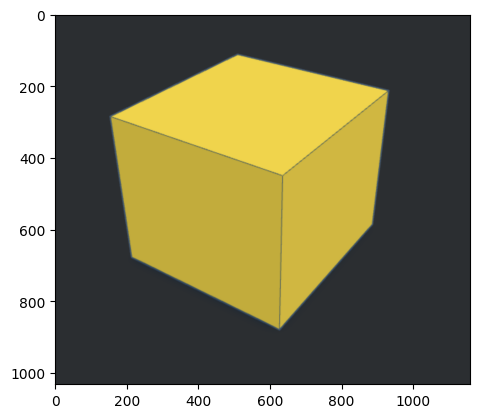

In [46]:
print(data)
plt.imshow(cubo_rgb)

In [47]:
#Since the image is the same, create an array with as many copies of the image as there are rows in the table
images = np.array([cubo_rgb] * len(data))  #Copy the image for each row

#Numerical data
features = data[['x', 'y', 'c', 'distance_from_center']].values

#The labels are the grasp coordinates
labels = data[['x', 'y']].values

#The labels for classification (0 for 'wrong', 1 for 'correct')
classification_labels = data[['evaluation']].values
#Resize the images
desired_size = (224, 224)
resized_images = np.array([cv2.resize(img, desired_size) for img in images])
print(resized_images.shape)

(1500, 224, 224, 3)


**DATA AUGMENTATION**

In [48]:
import imgaug as ia
import numpy as np

def update_labels(features, transformation):
    """
    Updates the x, y coordinates of the features based on the transformations applied by the augmentation pipeline.

    Args:
        features (np.array): An array with the original features (x, y coordinates, etc.).
        transformation_pipeline: The pipeline of transformations applied to the images.

    Returns:
        np.array: The updated features with the new x, y coordinates.
    """

    new_features = features.copy()

    # Extract x and y coordinates
    keypoints = [ia.KeypointsOnImage([ia.Keypoint(x=feature[0], y=feature[1])], shape=(224, 224, 3)) for feature in new_features]

    # Apply the same transformation used for the images
    augmented_keypoints = transformation.augment_keypoints(keypoints)

    # Update the features with new x,y coordinates
    for i, keypoint in enumerate(augmented_keypoints):
        new_features[i, 0] = keypoint.keypoints[0].x
        new_features[i, 1] = keypoint.keypoints[0].y

    return new_features

In [49]:
import imgaug.augmenters as iaa
import numpy as np

# Define the new versions number to be created for each image
num_augmented_versions = 5

# Define the transformations
augmentation_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
    iaa.Affine(rotate=(-20, 20)),  # Random rotation between -20 and +20 degrees
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Traslation
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))  # Adding of Gaussian noise
])

# Initialize the lists for images and augmented data
augmented_images = []
augmented_features = []
augmented_labels = []
augmented_classification_labels = []

# Loop to generate new augmented versions
for i in range(num_augmented_versions):
    # Data augmentation application
    new_images = augmentation_pipeline(images=resized_images)
    new_features = update_labels(features, augmentation_pipeline)  # Feature update
    new_labels = labels  # Keep the labels
    new_classification_labels = classification_labels  # Keep the classification labels

    # Add new augmented versions to the lists
    augmented_images.append(new_images)
    augmented_features.append(new_features)
    augmented_labels.append(new_labels)
    augmented_classification_labels.append(new_classification_labels)

# Concatenate the augmented data
augmented_images = np.concatenate(augmented_images, axis=0)
augmented_features = np.concatenate(augmented_features, axis=0)
augmented_labels = np.concatenate(augmented_labels, axis=0)
augmented_classification_labels = np.concatenate(augmented_classification_labels, axis=0)

print("Forme dei dati:")
print("Immagini:", augmented_images.shape)
print("Caratteristiche:", augmented_features.shape)
print("Etichette:", augmented_labels.shape)
print("Labels:", augmented_classification_labels.shape)
print(np.unique(classification_labels))

Forme dei dati:
Immagini: (7500, 224, 224, 3)
Caratteristiche: (7500, 4)
Etichette: (7500, 2)
Labels: (7500, 1)
[0 1]


**SAVING THE DATASET**

In [50]:
!pip install h5py

In [51]:
import h5py

with h5py.File('dataset.h5', 'w') as f:
    #Save the images
    f.create_dataset('images', data=augmented_images)

    #Save numerical data
    f.create_dataset('features', data=augmented_features)
    f.create_dataset('labels', data=augmented_labels)
    f.create_dataset('classification_labels', data=augmented_classification_labels)


**LOADING THE DATASET**

In [ ]:
with h5py.File('dataset.h5', 'r') as f:
    images = f['images'][:]
    features = f['features'][:]
    labels = f['labels'][:]
    classification_labels = f['classification_labels'][:]

**MODEL IMPORTS**

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

**CLASSIFICATION MODEL**

In [27]:
print("Data Structures:")
print("Images:", images.shape)
print("Features:", features.shape)
print("Labels:", labels.shape)
print("Classification Labels:", classification_labels.shape)
print(np.unique(classification_labels))

Data Structures:
Images: (1500, 224, 224, 3)
Features: (1500, 4)
Labels: (1500, 2)
Classification Labels: (1500, 1)
[0 1]


**DATA PREPARATION**

In [28]:
# Images normalization
images_normalized = images / 255.0

# Divide the data in training set and test set
X_train, X_test, y_train, y_test, y_class_train, y_class_test = train_test_split(
    images_normalized, labels, classification_labels, test_size=0.2, random_state=42
)
# Verify the dimensions
print("Shape of X_train:", X_train.shape)  # We suppose that the shape is (480, 224, 224, 3)
print("Shape of X_train:", y_train.shape)

# Computing the number of batches per epoch
batch_size = 32
num_samples = X_train.shape[0]
num_batches = (num_samples + batch_size - 1) // batch_size  # Rounding up
print("Numero di batch per epoca:", num_batches)

Shape of X_train: (1200, 224, 224, 3)
Shape of X_train: (1200, 2)
Numero di batch per epoca: 38


**Definition of the LINEAR MODEL: the output is the grasp coordinate**

In [28]:
# Parameters
input_shape = (224, 224, 3)  # Input image (224x224 RGB)
num_grasps = 2  # coordinates x and y

# Model definition
model = Sequential()

# Add the input layer
model.add(Input(shape=input_shape))

# Convolutional and Pooling layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening and fully-connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_grasps, activation='linear'))  # Prediction of grasp coordinates

# Model compilation
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy'])

**Class-weights computation**

In [29]:
# Assuming that classification_labels is an array with values 0 (incorrect) and 1 (correct)
class_weights = compute_class_weight('balanced', classes=[0, 1], y=classification_labels.flatten())

# Creating a dictionary with the class-weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

**Model training**

In [30]:
history = model.fit(X_train, y_train, class_weight=class_weight_dict, epochs=30, batch_size=32)
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", y_train.shape)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.5807 - loss: 581671.7500
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.5930 - loss: 155305.4531
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.5991 - loss: 182348.1562
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.6016 - loss: 166050.4531
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.5835 - loss: 181393.2344
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.6075 - loss: 173054.5156
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.5779 - loss: 158198.9531
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.6031 - loss: 157279.5156
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.6106 - loss: 154857.1406
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.5870 - loss: 151354.1719
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.5976 - loss: 158579.6719
Epoch 12

Model evaluation

In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 827ms/step - accuracy: 0.5930 - loss: 40197.2266
Test Loss: 41344.52734375, Test Accuracy: 0.5976190567016602


Prediction and error computation

In [32]:
# Making predictions
predictions = model.predict(X_test)

# Computing the error
errors = np.sqrt(np.sum((predictions - y_test) ** 2, axis=1))
print(f"Errore medio: {np.mean(errors)}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 800ms/step
Errore medio: 264.9925531318931


***IMAGE LOADING***

In [33]:
# Load an image fom the computer
uploaded = files.upload()

new_image_path = list(uploaded.keys())[0]
new_image = cv2.imdecode(np.frombuffer(uploaded[new_image_path], np.uint8), cv2.IMREAD_COLOR)
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

Saving Cubo_rosa.png to Cubo_rosa.png


In [34]:
def preprocess_image(new_image_rgb, target_size=(224, 224)):
    new_image_resized = cv2.resize(new_image_rgb, target_size)
    new_image_normalized = new_image_resized / 255.0
    new_image_input = np.expand_dims(new_image_normalized, axis=0)
    return new_image_input

In [35]:
def predict_grasp(model, new_image_input):
    predicted_grasp = model.predict(new_image_input)
    return predicted_grasp[0]

RESULT VISUALIZATION

In [36]:
def generate_model_based_grasp_positions(model, new_image_rgb, num_positions=5, input_shape=(224, 224), stride=30):
    original_height, original_width = new_image_rgb.shape[:2]
    grasp_positions = []
    grasp_scores = []

    # Image scanning with overlapping windows
    for y in range(0, original_height - input_shape[1] + 1, stride):
        for x in range(0, original_width - input_shape[0] + 1, stride):
            # Define the current region
            region = new_image_rgb[y:y + input_shape[1], x:x + input_shape[0]]
            region_input = preprocess_image(region, target_size=input_shape)

            # Use the model to predict the grasp for the region
            grasp_position = predict_grasp(model, region_input)

            # Use the central position of the region as grasp point
            grasp_x = x + input_shape[0] // 2
            grasp_y = y + input_shape[1] // 2

            # Save the grasp with the relative score (or probability)
            grasp_positions.append((grasp_x, grasp_y, grasp_position[0], grasp_position[1]))
            grasp_scores.append(np.linalg.norm(grasp_position))

    # Order the grasps accroding to the score, and select the best ones
    top_indices = np.argsort(grasp_scores)[-num_positions:][::-1]  # Be sure that the indexes are integer
    top_grasp_positions = [grasp_positions[i] for i in top_indices]

    best_grasp_index = top_indices[0]  # Grasp position index with the lowest score
    best_grasp_position = grasp_positions[best_grasp_index]
    return top_grasp_positions, best_grasp_position

In [37]:
def visualize_grasps(new_image_rgb, grasp_positions, best_grasp_position):

    plt.figure(figsize=(12, 12))
    plt.imshow(new_image_rgb)

    for (x, y, grasp_x, grasp_y) in grasp_positions:
        plt.scatter(x, y, color='red', marker='x', s=100)
        plt.text(x, y, f'({grasp_x:.2f}, {grasp_y:.2f})', color='white', fontsize=12, ha='right')

    # Underlines the best Grasp position
    best_x, best_y, best_grasp_x, best_grasp_y = best_grasp_position
    plt.scatter(best_x, best_y, color='green', marker='o', s=200, edgecolor='black')
    plt.text(best_x, best_y, f'Best ({best_grasp_x:.2f}, {best_grasp_y:.2f})', color='black', fontsize=14, ha='center')

    plt.title("Predicted Grasp Positions")
    plt.axis('on')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━

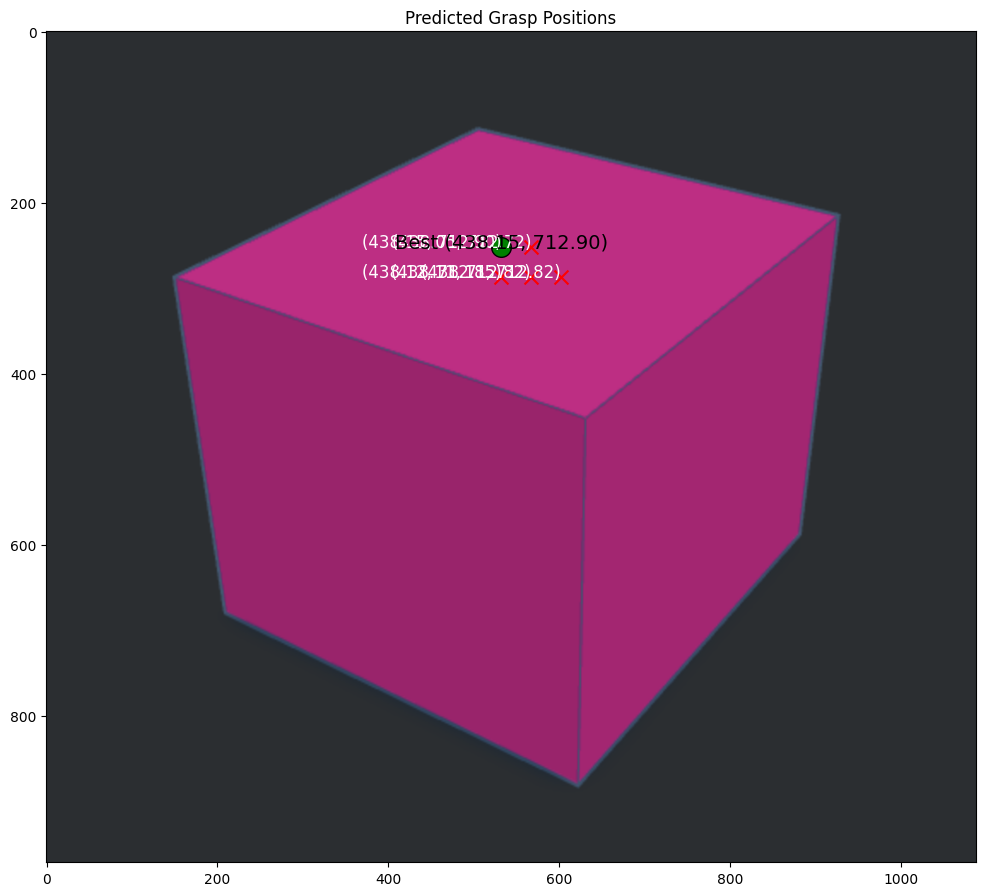

In [38]:
grasp_positions, best_grasp_position = generate_model_based_grasp_positions(model, new_image_rgb, num_positions=5, input_shape=(224, 224), stride=35)
visualize_grasps(new_image_rgb, grasp_positions, best_grasp_position)